<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Blepharoptosis_dryeye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


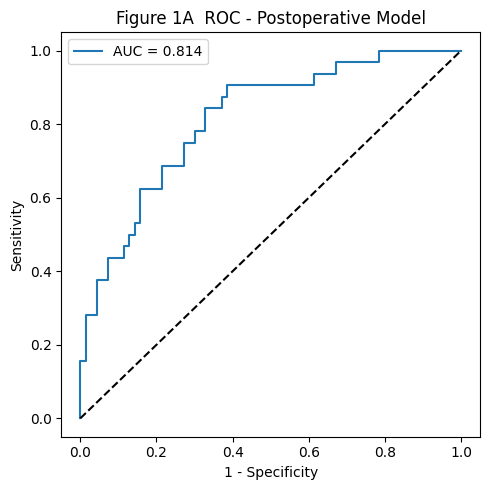

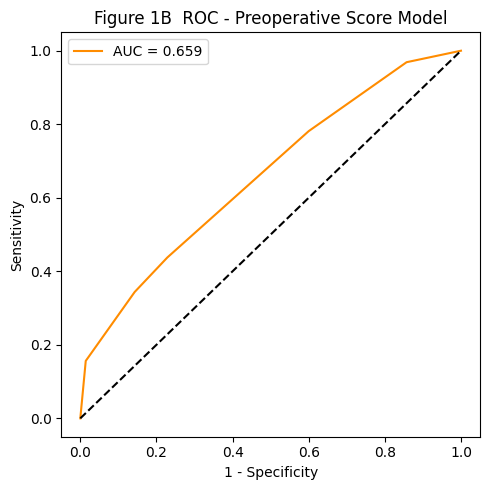

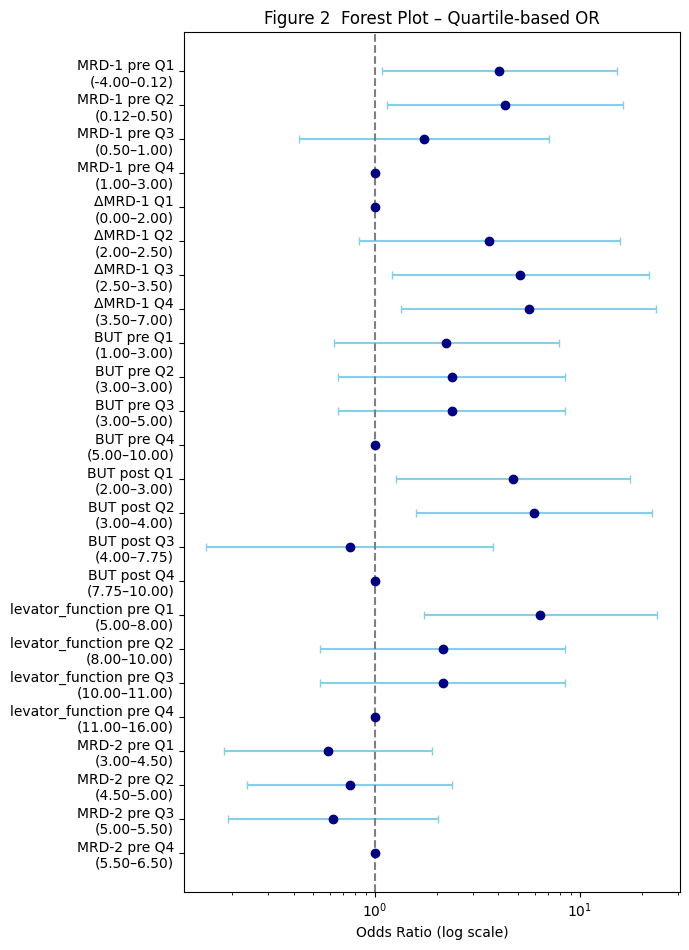

In [2]:
# Google Colabで動作する完全版スクリプト（日本語コメント付き）
# 保存先: /content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ.xlsx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import Table2x2

# Excelファイルの読み込み
file_path = "/content/drive/Shareddrives/岩崎Dr_IgG4 deulk/眼瞼下垂ドライアイ/眼瞼下垂★ドライアイ_kit.xlsx"
df_all = pd.read_excel(file_path, sheet_name="対象症例sides", header=0)

# ΔMRD-1を追加
df_all["ΔMRD-1"] = df_all["MRD-1 3M"] - df_all["MRD-1 pre"]

# 術前SPKが無い症例のみ抽出
df = df_all[df_all["SPK pre"] == 0].copy()

# ===============================
# Figure 1A：術後モデルのROC曲線
# ===============================
# 使用する変数（欠損除外）
post_cols = ["MRD-1 pre", "ΔMRD-1", "levator_function pre", "MRD-2 pre", "BUT pre", "BUT post"]
df_post = df[["SPK post"] + post_cols].dropna()

X_post = sm.add_constant(df_post[post_cols])
y_post = df_post["SPK post"]

# ロジスティック回帰モデルの構築
post_model = sm.Logit(y_post, X_post).fit(disp=False)

# 予測確率とROC曲線
y_prob_post = post_model.predict(X_post)
fpr_p, tpr_p, _ = roc_curve(y_post, y_prob_post)
auc_p = roc_auc_score(y_post, y_prob_post)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_p, tpr_p, label=f"AUC = {auc_p:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1A  ROC - Postoperative Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1A_ROC_postop.png", dpi=350)

# ===============================
# Figure 1B：スコアモデルのROC曲線
# ===============================
# スコア定義関数
def calc_score(row):
    score = 0
    if row["MRD-1 pre"] < 0.5:
        score += 2
    if row["ΔMRD-1"] >= 2.0:
        score += 1
    if row["BUT pre"] < 5:
        score += 1
    if row["levator_function pre"] < 8:
        score += 1
    return score

df["score"] = df.apply(calc_score, axis=1)
df_score = df[["score", "SPK post"]].dropna()

# モデル構築とROC
X_score = df_score[["score"]]
y_score = df_score["SPK post"]
model_score = LogisticRegression().fit(X_score, y_score)
y_prob_score = model_score.predict_proba(X_score)[:, 1]
fpr_s, tpr_s, _ = roc_curve(y_score, y_prob_score)
auc_s = roc_auc_score(y_score, y_prob_score)

# グラフ出力
plt.figure(figsize=(5, 5))
plt.plot(fpr_s, tpr_s, label=f"AUC = {auc_s:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Figure 1B  ROC - Preoperative Score Model")
plt.legend()
plt.tight_layout()
plt.savefig("Fig1B_ROC_preop.png", dpi=350)

# ===============================
# Figure 2：フォレストプロット（四分位OR）
# ===============================
# 対象変数
predictors = ["MRD-1 pre", "ΔMRD-1", "BUT pre", "BUT post", "levator_function pre", "MRD-2 pre"]

forest_data = []

for var in predictors:
    df_q = df[[var, "SPK post"]].dropna().copy()
    df_q["quartile"] = pd.qcut(df_q[var].rank(method="first"), 4, labels=["Q1", "Q2", "Q3", "Q4"])

    q_vals = df_q[var].quantile([0, 0.25, 0.5, 0.75, 1]).values
    ranges = {
        "Q1": f"{q_vals[0]:.2f}–{q_vals[1]:.2f}",
        "Q2": f"{q_vals[1]:.2f}–{q_vals[2]:.2f}",
        "Q3": f"{q_vals[2]:.2f}–{q_vals[3]:.2f}",
        "Q4": f"{q_vals[3]:.2f}–{q_vals[4]:.2f}"
    }

    # 基準群（リスク最小）を指定
    ref_q = "Q4" if var != "ΔMRD-1" else "Q1"

    for q in ["Q1", "Q2", "Q3", "Q4"]:
        if q == ref_q:
            forest_data.append((var, q, ranges[q], 1.0, 1.0, 1.0))
        else:
            a = ((df_q["quartile"] == q) & (df_q["SPK post"] == 1)).sum()
            b = ((df_q["quartile"] == q) & (df_q["SPK post"] == 0)).sum()
            c = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 1)).sum()
            d = ((df_q["quartile"] == ref_q) & (df_q["SPK post"] == 0)).sum()
            # 0セル補正
            if 0 in [a, b, c, d]:
                a += 0.5; b += 0.5; c += 0.5; d += 0.5
            table = Table2x2([[a, b], [c, d]])
            or_val = table.oddsratio
            ci_low, ci_high = table.oddsratio_confint()
            forest_data.append((var, q, ranges[q], or_val, ci_low, ci_high))

# データフレーム化
forest_df = pd.DataFrame(forest_data, columns=["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high"])
forest_df["Label"] = forest_df["Variable"] + " " + forest_df["Quartile"] + "\n(" + forest_df["Range"] + ")"

# プロット
plt.figure(figsize=(7, len(forest_df) * 0.4))
y_pos = np.arange(len(forest_df))[::-1]
plt.errorbar(forest_df["OR"], y_pos,
             xerr=[forest_df["OR"] - forest_df["CI_low"], forest_df["CI_high"] - forest_df["OR"]],
             fmt='o', color='navy', ecolor='skyblue', capsize=3)
plt.axvline(1, color='gray', linestyle='--')
plt.yticks(y_pos, forest_df["Label"])
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Figure 2  Forest Plot – Quartile-based OR")
plt.tight_layout()
plt.savefig("Fig2_Forest.png", dpi=350)



=== Table 1 summary statistics ===


,count,mean,std,min,25%,50%,75%,max,missing
MRD-1 pre,102.0,0.495098,1.188841,-4.0,0.125,0.5,1.00,3.0,0
ΔMRD-1,102.0,2.740196,1.328906,0.0,2.000,2.5,3.50,7.0,0
MRD-2 pre,102.0,4.862745,0.689945,3.0,4.500,5.0,5.50,6.5,0
levator_function pre,102.0,9.529412,2.201286,5.0,8.000,10.0,11.00,16.0,0
BUT pre,102.0,4.568627,2.752172,1.0,3.000,3.0,5.00,10.0,0
BUT post,102.0,5.480392,2.702146,2.0,3.000,4.0,7.75,10.0,0



=== 正規性検定 (Shapiro-Wilk) と ヒストグラム ===
MRD-1 pre                  Shapiro p = 0.0000 (非正規)


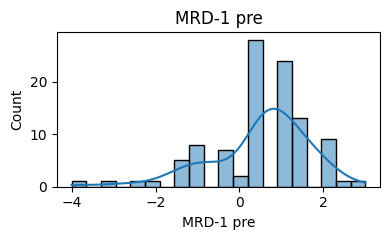

ΔMRD-1                     Shapiro p = 0.0314 (非正規)


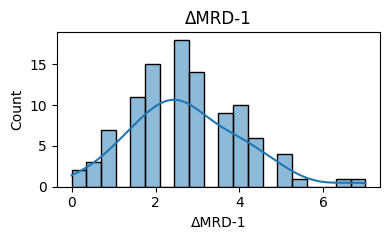

MRD-2 pre                  Shapiro p = 0.0004 (非正規)


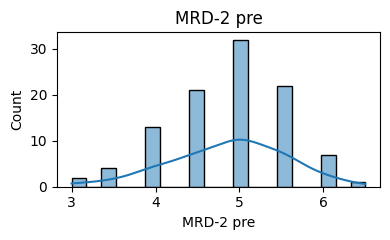

levator_function pre       Shapiro p = 0.0304 (非正規)


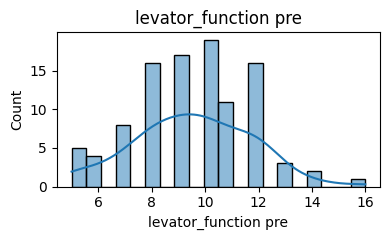

BUT pre                    Shapiro p = 0.0000 (非正規)


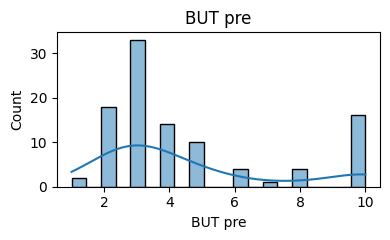

BUT post                   Shapiro p = 0.0000 (非正規)


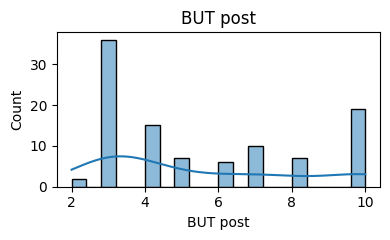


=== Table 2 単変量解析結果 ===
MRD-1 pre                 Mann-Whitney p = 0.0198
ΔMRD-1                    Mann-Whitney p = 0.0065
MRD-2 pre                 Mann-Whitney p = 0.1626
levator_function pre      t-test       p = 0.0008
BUT pre                   Mann-Whitney p = 0.2942
BUT post                  Mann-Whitney p = 0.0007

=== Table 2 多変量ロジスティック回帰 ===
                           Logit Regression Results                           
Dep. Variable:          Q('SPK post')   No. Observations:                  102
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            6
Date:                Sat, 10 May 2025   Pseudo R-squ.:                  0.2224
Time:                        20:32:06   Log-Likelihood:                -49.337
converged:                       True   LL-Null:                       -63.449
Covariance Type:            nonrobust   LLR p-value:                 8.526e-05
             

,Variable,Quartile,Range,OR,CI_low,CI_high
0,MRD-1 pre,Q1,-4.00–0.12,4.033333,1.078304,15.086442
1,MRD-1 pre,Q2,0.12–0.50,4.321429,1.147365,16.276208
2,MRD-1 pre,Q3,0.50–1.00,1.736842,0.425652,7.087054
3,MRD-1 pre,Q4,1.00–3.00,1.000000,1.000000,1.000000
4,ΔMRD-1,Q1,0.00–2.00,1.000000,1.000000,1.000000
5,ΔMRD-1,Q2,2.00–2.50,3.607843,0.831583,15.652715
6,ΔMRD-1,Q3,2.50–3.50,5.111111,1.205039,21.678510
7,ΔMRD-1,Q4,3.50–7.00,5.622222,1.341728,23.558719
8,BUT pre,Q1,1.00–3.00,2.223529,0.626628,7.889975
9,BUT pre,Q2,3.00–3.00,2.362500,0.662099,8.429867


In [8]:
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
from statsmodels.formula.api import logit
import statsmodels.api as sm
from itertools import combinations

# ===============================
# Table 1: 基本統計量の表示
# ===============================
columns_of_interest = [
    "MRD-1 pre", "ΔMRD-1", "MRD-2 pre", "levator_function pre", "BUT pre", "BUT post"
]

# 平均、標準偏差、四分位、欠損数
summary_table1 = df[columns_of_interest].describe(percentiles=[.25, .5, .75]).T
summary_table1["missing"] = df[columns_of_interest].isnull().sum()
print("\n=== Table 1 summary statistics ===")
display(summary_table1)

# ===============================
# 正規性検定 + ヒストグラム描画
# ===============================
print("\n=== 正規性検定 (Shapiro-Wilk) と ヒストグラム ===")
for col in columns_of_interest:
    data_clean = df[col].dropna()
    stat, p = shapiro(data_clean)
    print(f"{col:<25}  Shapiro p = {p:.4f} {'(正規)' if p > 0.05 else '(非正規)'}")

    # ヒストグラム表示
    plt.figure(figsize=(4, 2.5))
    sns.histplot(data_clean, kde=True, bins=20)
    plt.title(f"{col}")
    plt.tight_layout()
    plt.show()

# ===============================
# Table 2: 単変量 & 多変量ロジスティック解析
# ===============================
print("\n=== Table 2 単変量解析結果 ===")
for col in columns_of_interest:
    group0 = df[df["SPK post"] == 0][col].dropna()
    group1 = df[df["SPK post"] == 1][col].dropna()

    # Shapiroで両群が正規ならt検定、それ以外はMann-Whitney
    p0 = shapiro(group0)[1]
    p1 = shapiro(group1)[1]
    if p0 > 0.05 and p1 > 0.05:
        stat, p = ttest_ind(group0, group1)
        method = "t-test"
    else:
        stat, p = mannwhitneyu(group0, group1)
        method = "Mann-Whitney"
    print(f"{col:<25} {method:<12} p = {p:.4f}")

# 多変量ロジスティック（同じ変数で回帰）
df_mv = df[["SPK post"] + columns_of_interest].dropna()
formula = "Q('SPK post') ~ " + " + ".join([f"Q('{v}')" for v in columns_of_interest])
model = logit(formula, data=df_mv).fit(disp=0)
print("\n=== Table 2 多変量ロジスティック回帰 ===")
print(model.summary())

# Stepwise
columns_of_interest = [
    "MRD-1 pre", "ΔMRD-1", "MRD-2 pre", "levator_function pre", "BUT pre", "BUT post"
]
def stepwise_selection_aic(X, y, initial_list=[], verbose=True):
    """AICを基準としたステップワイズ法（前進・後退選択）"""
    included = list(initial_list)
    best_aic = np.inf
    while True:
        changed = False
        candidates = []

        # 前進ステップ：追加候補ごとにAICを評価
        excluded = list(set(X.columns) - set(included))
        for new_col in excluded:
            try:
                model = sm.Logit(y, sm.add_constant(X[included + [new_col]])).fit(disp=0)
                candidates.append((model.aic, new_col, 'add'))
            except Exception:
                continue

        # 後退ステップ：既存の変数を1つずつ除いてAICを評価
        for remove_col in included:
            try:
                reduced = [c for c in included if c != remove_col]
                model = sm.Logit(y, sm.add_constant(X[reduced])).fit(disp=0)
                candidates.append((model.aic, remove_col, 'drop'))
            except Exception:
                continue

        # 最もAICが下がる変更を採用
        if not candidates:
            break
        candidates.sort()
        best_candidate = candidates[0]
        if best_candidate[0] < best_aic - 1e-4:  # AICが改善されたら更新
            best_aic = best_candidate[0]
            var, action = best_candidate[1], best_candidate[2]
            if action == 'add':
                included.append(var)
                if verbose:
                    print(f"Add   {var:<25} AIC = {best_candidate[0]:.2f}")
            elif action == 'drop':
                included.remove(var)
                if verbose:
                    print(f"Drop  {var:<25} AIC = {best_candidate[0]:.2f}")
            changed = True
        if not changed:
            break

    # 最終モデル出力
    final_model = sm.Logit(y, sm.add_constant(X[included])).fit(disp=0)
    print("\n=== AICによるステップワイズ選択 最終モデル ===")
    print(final_model.summary())
    return included, final_model

# columns_of_interest と df が既に定義されている前提
df_mv = df[["SPK post"] + columns_of_interest].dropna()
X_step = df_mv.drop(columns=["SPK post"])
y_step = df_mv["SPK post"]

# ステップワイズ実行
selected_vars, stepwise_model = stepwise_selection_aic(X_step, y_step)


# ===============================
# Figure 2 の元データ表示（Forest用OR）
# ===============================
print("\n=== Forest Plot ORs by Quartile ===")
display(forest_df[["Variable", "Quartile", "Range", "OR", "CI_low", "CI_high"]])
